# **Breast Cancer Wisconsin Classification**

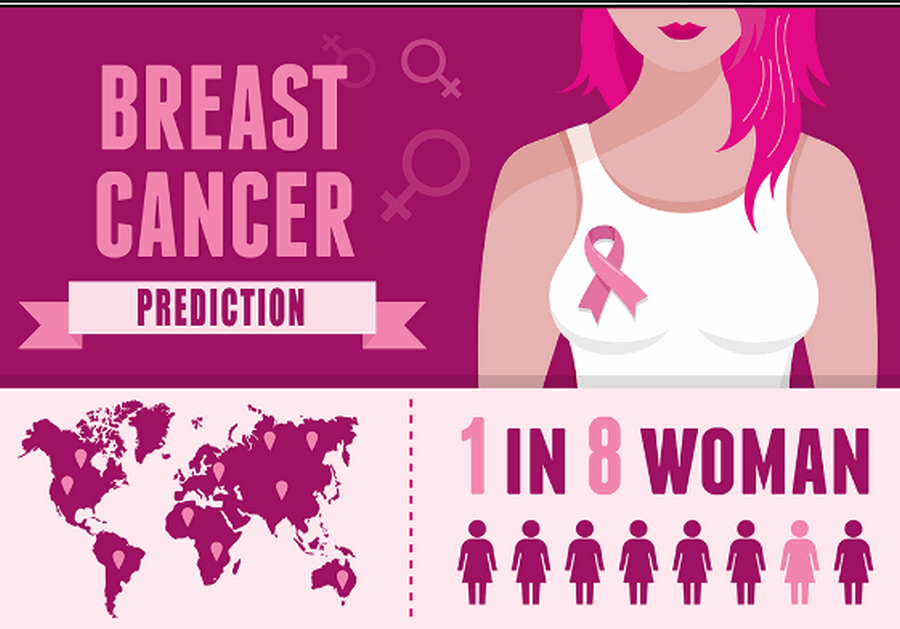

## **About Data:**

The Breast Cancer Wisconsin (Diagnostic) dataset is a popular dataset used for binary classification tasks in machine learning, particularly in identifying whether a tumor is malignant (cancerous) or benign (non-cancerous) based on various features extracted from images of cell nuclei.

**1. ID number**

A unique identifier for each data entry (patient or tumor sample).
* Shall not be used for modeling — it’s just metadata.


**2. Diagnosis**

Target variable (label).
* Two classes:

 * **M** = Malignant (cancerous)

 * **B** = Benign (non-cancerous)


**3. Ten Real-Valued Features**

(These are statistical measurements computed from digital images of fine needle aspirate (FNA) of breast masses.)


| Feature               | Description                                                                                                                               |
| --------------------- | ----------------------------------------------------------------------------------------------------------------------------------------- |
| **Radius**            | Average distance from the center to the perimeter. Larger radius may suggest malignancy.                                                  |
| **Texture**           | Standard deviation of gray-scale intensities — measures variation in texture. Higher variability might indicate malignancy.               |
| **Perimeter**         | Total length around the cell nucleus boundary. Correlated with radius.                                                                    |
| **Area**              | Area of the cell nucleus. Larger area may suggest malignancy.                                                                             |
| **Smoothness**        | How smooth the edges of the nucleus are. Lower smoothness = bumpier edges, which may indicate cancer.                                     |
| **Compactness**       | Defined as $(\text{perimeter}^2 / \text{area}) - 1.0$. Higher values often mean less compact or more irregular shapes.                    |
| **Concavity**         | Degree of concave (inward-curving) portions of the contour. More concavity can be a sign of malignancy.                                   |
| **Concave Points**    | Number of concave points on the contour. Higher count may indicate more irregular shape.                                                  |
| **Symmetry**          | How symmetric the cell shape is. Less symmetry may be associated with malignancy.                                                         |
| **Fractal Dimension** | A measure of the "roughness" or complexity of the perimeter (like the "coastline" analogy). Higher values suggest more irregular borders. |

---

 **Notes:**

 * Each feature is computed as the **mean**, **standard error**, and **worst (largest)** value
 * High values for each feature indicate increased potential malignancy (except for Smoothness and Symmetry)






---
---

## **Libraries Used:**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Evaluation metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import time
# Ignore all warnings
warnings.filterwarnings('ignore')

---
---

## **1. Initial Pre-Processing**

In [9]:
# Loading the data
df = pd.read_csv('BreastCancerWisconsin.csv')

In [10]:
# Checking dataset dimensions
df.shape

(569, 33)

In [11]:
# Show all columns
pd.set_option('display.max_columns', None)

# Displaying sample records
df.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
169,8712853,B,14.97,16.95,96.22,685.9,0.09855,0.07885,0.02602,0.03781,0.1780,0.05650,0.2713,1.2170,1.893,24.28,0.005080,0.01370,0.007276,0.009073,0.01350,0.001706,16.11,23.00,104.60,793.7,0.1216,0.1637,0.06648,0.08485,0.2404,0.06428,NaN
378,9013594,B,13.66,15.15,88.27,580.6,0.08268,0.07548,0.04249,0.02471,0.1792,0.05897,0.1402,0.5417,1.101,11.35,0.005212,0.02984,0.024430,0.008356,0.01818,0.004868,14.54,19.64,97.96,657.0,0.1275,0.3104,0.25690,0.10540,0.3387,0.09638,NaN
310,893783,B,11.70,19.11,74.33,418.7,0.08814,0.05253,0.01583,0.01148,0.1936,0.06128,0.1601,1.4300,1.109,11.28,0.006064,0.00911,0.010420,0.007638,0.02349,0.001661,12.61,26.55,80.92,483.1,0.1223,0.1087,0.07915,0.05741,0.3487,0.06958,NaN
57,857793,M,14.71,21.59,95.55,656.9,0.11370,0.13650,0.12930,0.08123,0.2027,0.06758,0.4226,1.1500,2.735,40.09,0.003659,0.02855,0.025720,0.012720,0.01817,0.004108,17.87,30.70,115.70,985.5,0.1368,0.4290,0.35870,0.18340,0.3698,0.10940,NaN
497,914580,B,12.47,17.31,80.45,480.1,0.08928,0.07630,0.03609,0.02369,0.1526,0.06046,0.1532,0.7810,1.253,11.91,0.003796,0.01371,0.013460,0.007096,0.01536,0.001541,14.06,24.34,92.82,607.3,0.1276,0.2506,0.20280,0.10530,0.3035,0.07661,NaN
436,908916,B,12.87,19.54,82.67,509.2,0.09136,0.07883,0.01797,0.02090,0.1861,0.06347,0.3665,0.7693,2.597,26.50,0.005910,0.01362,0.007066,0.006502,0.02223,0.002378,14.45,24.38,95.14,626.9,0.1214,0.1652,0.07127,0.06384,0.3313,0.07735,NaN
476,911654,B,14.20,20.53,92.41,618.4,0.08931,0.11080,0.05063,0.03058,0.1506,0.06009,0.3478,1.0180,2.749,31.01,0.004107,0.03288,0.028210,0.013500,0.01610,0.002744,16.45,27.26,112.10,828.5,0.1153,0.3429,0.25120,0.13390,0.2534,0.07858,NaN
252,885429,M,19.73,19.82,130.70,1206.0,0.10620,0.18490,0.24170,0.09740,0.1733,0.06697,0.7661,0.7800,4.115,92.81,0.008482,0.05057,0.068000,0.019710,0.01467,0.007259,25.28,25.59,159.80,1933.0,0.1710,0.5955,0.84890,0.25070,0.2749,0.12970,NaN
369,9012000,M,22.01,21.90,147.20,1482.0,0.10630,0.19540,0.24480,0.15010,0.1824,0.06140,1.0080,0.6999,7.561,130.20,0.003978,0.02821,0.035760,0.014710,0.01518,0.003796,27.66,25.80,195.00,2227.0,0.1294,0.3885,0.47560,0.24320,0.2741,0.08574,NaN
171,87163,M,13.43,19.63,85.84,565.4,0.09048,0.06288,0.05858,0.03438,0.1598,0.05671,0.4697,1.1470,3.142,43.40,0.006003,0.01063,0.021510,0.009443,0.01520,0.001868,17.98,29.87,116.60,993.6,0.1401,0.1546,0.26440,0.11600,0.2884,0.07371,NaN


In [12]:
# Dropping Unnecessay/irrelevant Columns
df = df.drop(['id', 'Unnamed: 32'], axis=1)

In [13]:
# Verifying column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

All data is Numerical (except the target column) with compatible data types.

Target Column (Binary Classification)- Method: **Binary Mapping**

 * **M** = Malignant (cancerous) --> 1

 * **B** = Benign (non-cancerous) --> 0

In [15]:
df['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [16]:
# Binary Mapping target
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [17]:
df.sample(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
456,0,11.63,29.29,74.87,415.1,0.09357,0.08574,0.07160,0.020170,0.1799,0.06166,0.3135,2.4260,2.150,23.130,0.009861,0.024180,0.042750,0.009215,0.02475,0.002128,13.12,38.81,86.04,527.8,0.1406,0.2031,0.29230,0.06835,0.2884,0.07220
313,0,11.54,10.72,73.73,409.1,0.08597,0.05969,0.01367,0.008907,0.1833,0.06100,0.1312,0.3602,1.107,9.438,0.004124,0.013400,0.010030,0.004667,0.02032,0.001952,12.34,12.87,81.23,467.8,0.1092,0.1626,0.08324,0.04715,0.3390,0.07434
346,0,12.06,18.90,76.66,445.3,0.08386,0.05794,0.00751,0.008488,0.1555,0.06048,0.2430,1.1520,1.559,18.020,0.007180,0.010960,0.005832,0.005495,0.01982,0.002754,13.64,27.06,86.54,562.6,0.1289,0.1352,0.04506,0.05093,0.2880,0.08083
458,0,13.00,25.13,82.61,520.2,0.08369,0.05073,0.01206,0.017620,0.1667,0.05449,0.2621,1.2320,1.657,21.190,0.006054,0.008974,0.005681,0.006336,0.01215,0.001514,14.34,31.88,91.06,628.5,0.1218,0.1093,0.04462,0.05921,0.2306,0.06291
468,1,17.60,23.33,119.00,980.5,0.09289,0.20040,0.21360,0.100200,0.1696,0.07369,0.9289,1.4650,5.801,104.900,0.006766,0.070250,0.065910,0.023110,0.01673,0.011300,21.57,28.87,143.60,1437.0,0.1207,0.4785,0.51650,0.19960,0.2301,0.12240


In [18]:
# Checking for duplicate entries
df.duplicated().sum()

0

In [19]:
# Identifying missing values
df.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

---
---

## **2. Exploratory Data Analysis (EDA) & Data Transformation**

### **A. Univariate Analysis**

In [23]:
# Statistical Summary
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### **Thoughts Based on Statistical Summary:**

**1. Feature Scale Varies Significantly**

* **`area_mean`** ranges from **143.5** to **2501**, while features like **`fractal_dimension_mean`** range only from **\~0.05 to 0.097**.

Method: **Standardization or normalization** is **crucial** before applying ML models sensitive to scale (like SVM).

---
**2. Potential Outliers**

* Some features like:

  * **`area_worst`**: max = 4254, mean = 880 → very high spread!
  * **`perimeter_worst`**: max = 251.2 vs mean = 107.26
  * **`concavity_worst`**: max = 1.252 vs mean = 0.272

Method: **EDA Analysis** (visualization with **box plots** to check if  outliers should be treated).

---

 **3. Discriminative Features**

Features that show **large differences in range and max values** are usually good at separating benign from malignant:

* **`radius_mean`, `area_mean`, `concavity_mean`, `compactness_mean`** → very large max values and std deviation.
* These are **likely to have strong correlation** with diagnosis.

Method: **EDA Analysis** (**correlation heatmaps** or **feature importance** plots)

---

**4. Feature Skewness**

* **`concavity_se`, `compactness_se`, `area_se`** → large gaps between min and max
* Their **mean is far from the max**, suggesting possible **right skew**.

Method: **log transformation** or **normalization** to handle algorithms sensitive to distribution assumptions.

---
**5. Low Variance Features**

* **`smoothness_se`, `fractal_dimension_se`** have **very low std devs** and very small ranges (e.g., 0.0017 to 0.031) Could be **less useful** for classification

Method: **feature selection**

---

**6. No Missing Values**

* `count` = 569 for all features → dataset is **complete**.

No need for imputation — nice and clean.

---

### **1- Detecting and handling outliers**

#### **Checking Outliers: BoxPlot**

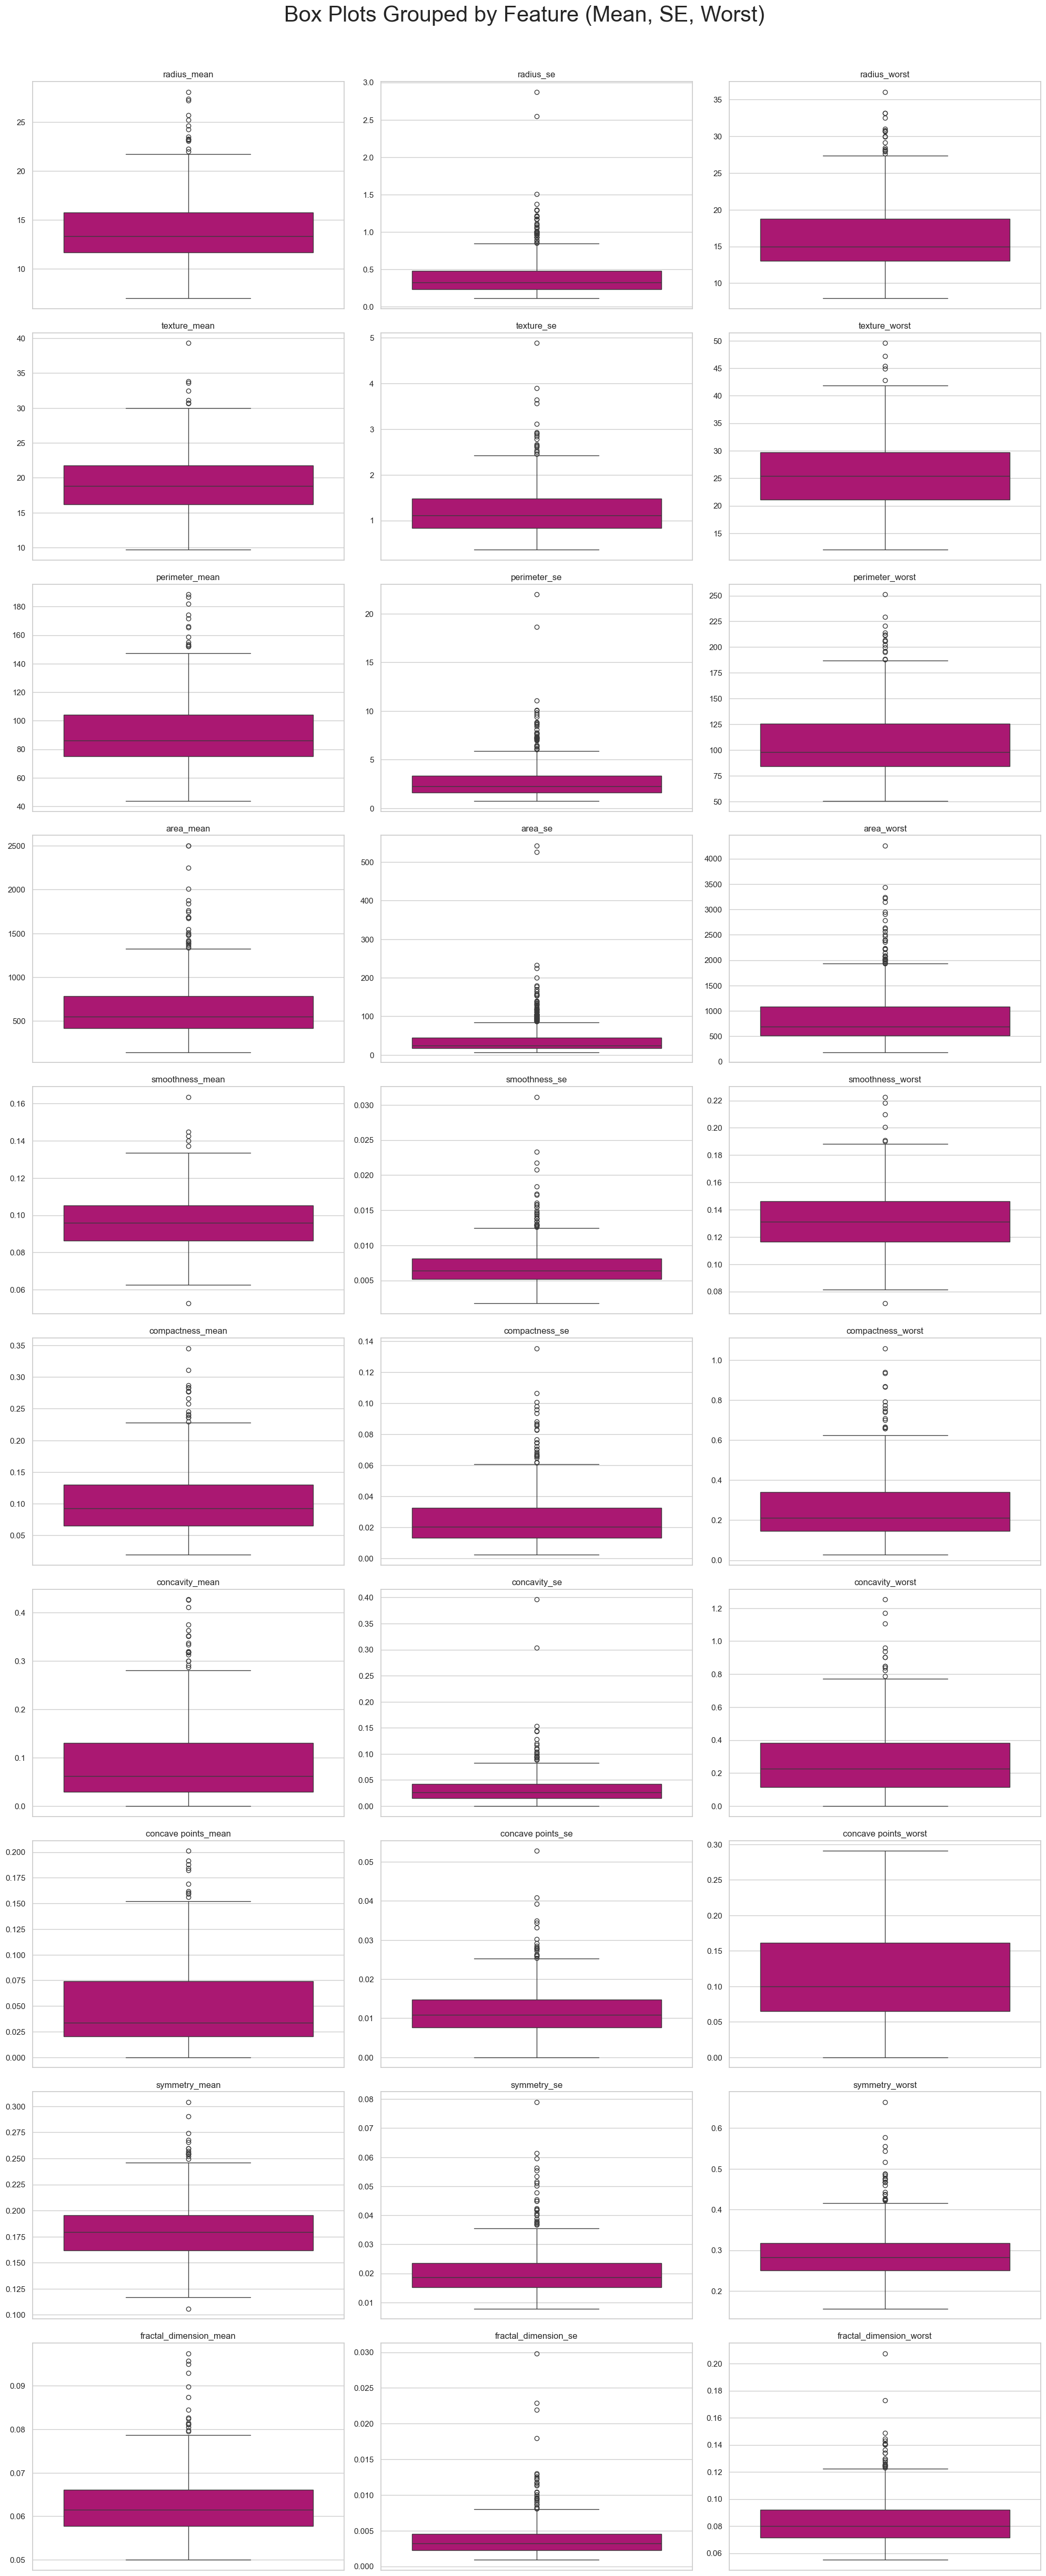

In [27]:
# Group features by base name
base_features = ['radius', 'texture', 'perimeter', 'area', 'smoothness',
                 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal_dimension']

# Get all 30 features
data = df.drop('diagnosis', axis=1)
feature_ordered = []
for base in base_features:
    # Match mean, se, worst for the base feature
    mean_col = f'{base}_mean'
    se_col = f'{base}_se'
    worst_col = f'{base}_worst'
    feature_ordered.extend([mean_col, se_col, worst_col])

# Plot settings
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 50))  # 10 rows, 3 cols
fig.suptitle('Box Plots Grouped by Feature (Mean, SE, Worst)', fontsize=30)
plt.subplots_adjust(hspace=0.6, wspace=0.4)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each feature in the desired order
for i, feature in enumerate(feature_ordered):
    sns.boxplot(ax=axes[i], y=data[feature], color= '#C20078')
    axes[i].set_title(feature, fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

**Handelling Outliers: Clipping**

**Advantages:**

- Keeps all rows

- Reduces outlier influence

- Safe for models like  SVM

To keep the original data's overall structure, only most extreme 5% of values (Major Outliers) will be capped, keeping 95% unchanged

In [29]:
# Capping values at the 2.5th and 97.5th percentiles.

capped_df = df.copy()
features = capped_df.drop(columns='diagnosis').columns

for col in features:
    lower = capped_df[col].quantile(0.025)
    upper = capped_df[col].quantile(0.975)
    capped_df[col] = capped_df[col].clip(lower, upper)

# Apply Capping to actual df
df = capped_df

Re-Check the Boxplot:

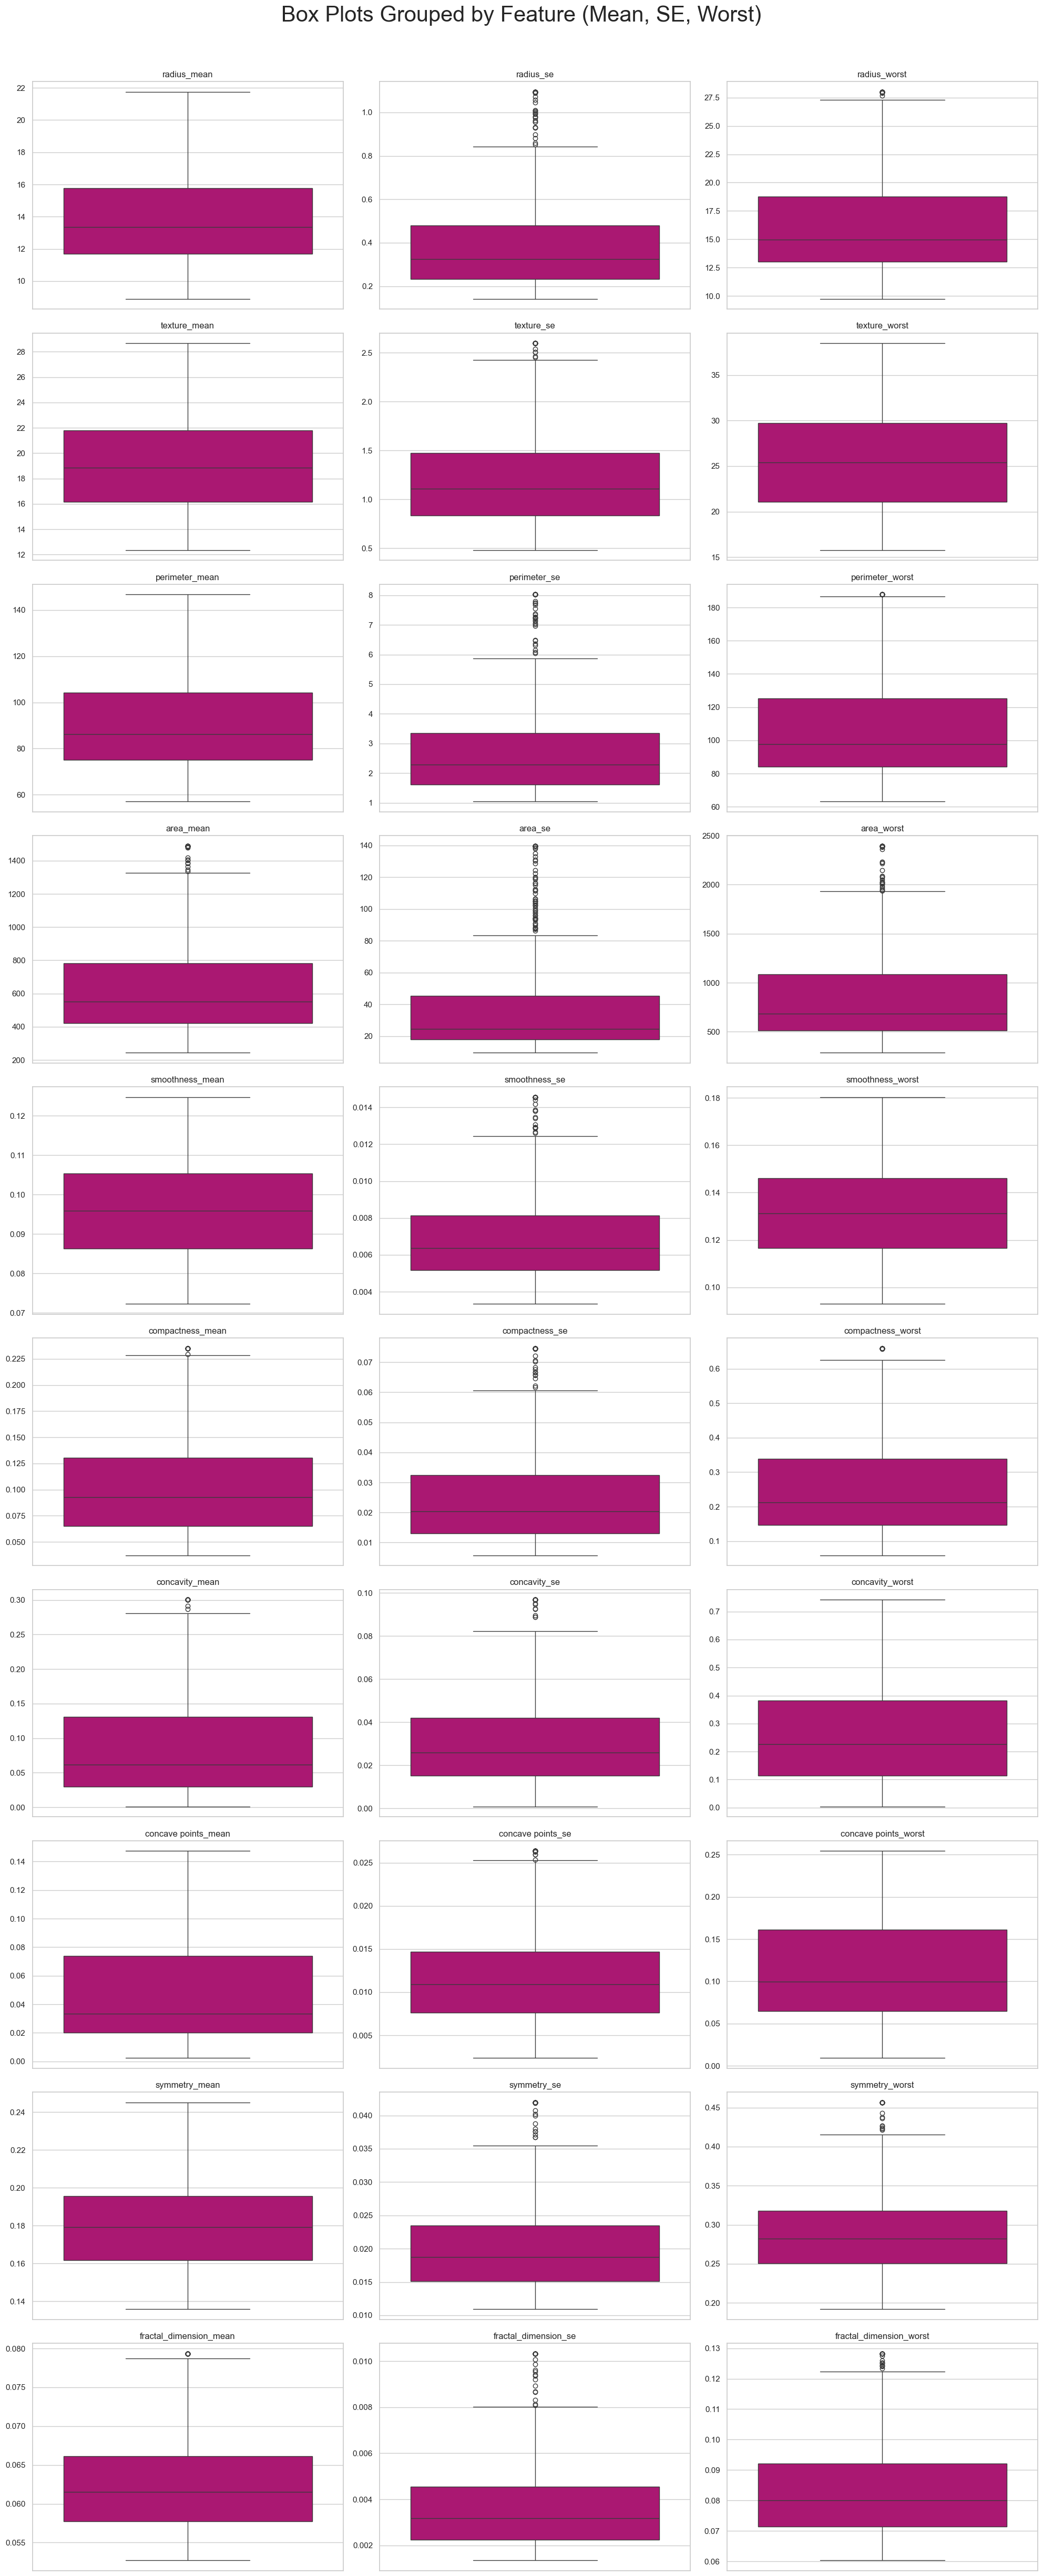

In [31]:
# Group features by base name
base_features = ['radius', 'texture', 'perimeter', 'area', 'smoothness',
                 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal_dimension']

# Get all 30 features
data = df.drop('diagnosis', axis=1)
feature_ordered = []
for base in base_features:
    # Match mean, se, worst for the base feature
    mean_col = f'{base}_mean'
    se_col = f'{base}_se'
    worst_col = f'{base}_worst'
    feature_ordered.extend([mean_col, se_col, worst_col])

# Plot settings
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 50))  # 10 rows, 3 cols
fig.suptitle('Box Plots Grouped by Feature (Mean, SE, Worst)', fontsize=30)
plt.subplots_adjust(hspace=0.6, wspace=0.4)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each feature in the desired order
for i, feature in enumerate(feature_ordered):
    sns.boxplot(ax=axes[i], y=data[feature], color= '#C20078')
    axes[i].set_title(feature, fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

* **`mean` columns** are generally well-behaved after clipping.
* **`worst` columns** have a few remaining outliers — potentially informative but not overwhelming.
*  **`se` columns** often contain many outliers and high variance due to how they're computed (standard errors tend to be noisier by nature).



In next step, Let's Focus on **Feature Selection via Correlation + Domain Knowledge**

and maybe re-consider `se` columns cleanup Only if they show strong correlation.




---

### **B. Bivariate/Multivariate Analysis**

### **2- Correlation & Feature Importance Analysis**




#### **First) Checking Feature-Feature Relationships**

Goal: Identify redundant groups (e.g., radius_mean, radius_worst) before judging their correlation with the target (brute-force filtering).

Text(0.5, 1.0, 'Feature-Feature Correlations')

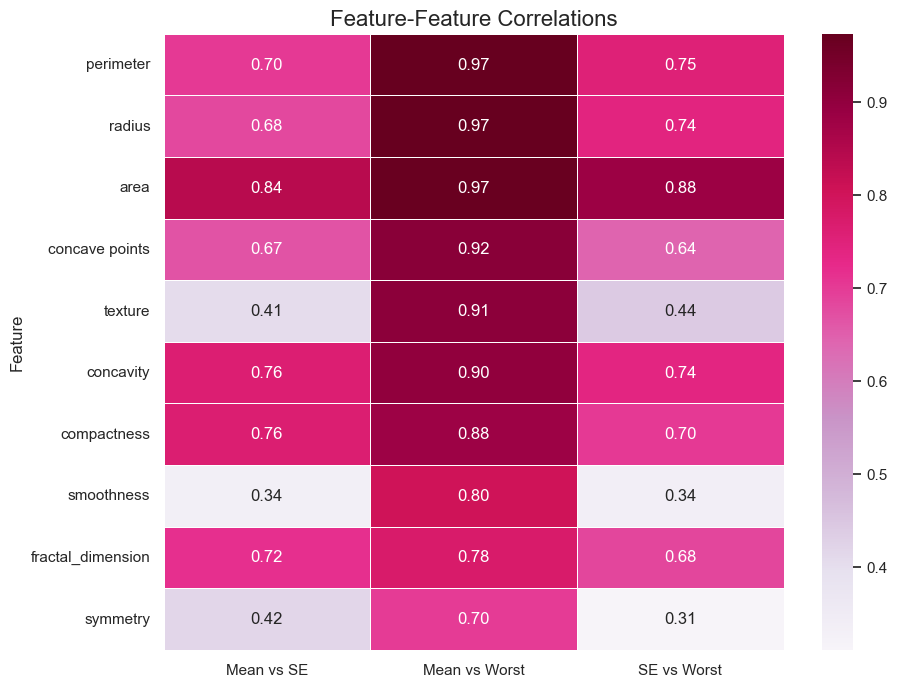

In [37]:
# Extract the base feature names (before "_mean")
base_features = [col.replace('_mean', '') for col in df.columns if '_mean' in col]

# Ensure all three forms exist
valid_groups = [
    (f"{base}_mean", f"{base}_se", f"{base}_worst")
    for base in base_features
    if f"{base}_mean" in df.columns and f"{base}_se" in df.columns and f"{base}_worst" in df.columns
]

# Compute pairwise correlations
correlations = []
for mean, se, worst in valid_groups:
    correlations.append({
        'Feature': mean.replace('_mean', ''),
        'Mean vs SE': df[mean].corr(df[se]),
        'Mean vs Worst': df[mean].corr(df[worst]),
        'SE vs Worst': df[se].corr(df[worst])
    })

# Create DataFrame
corr_df = pd.DataFrame(correlations).set_index('Feature').sort_values(by='Mean vs Worst', ascending=False)

# Visualize as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='PuRd', fmt=".2f", linewidths=.5)
plt.title('Feature-Feature Correlations', fontsize=16)

As Expected Mean and Worst has a rather high Consistent Correlation,usually:

- High correlation ( > 0.9): Better drop Mean (redundant); Since "worst-case" values are clinically significant (predicting aggressive outcomes) important to predict Maligenancy.

- Moderate correlation (0.7–0.9): A need to Test if Mean improves model performance.

**Testing Model Performance (Random Forest)**

In [40]:
y = df['diagnosis']
mean_features = [col for col in df.columns if '_mean' in col]
worst_features = [col.replace('_mean', '_worst') for col in mean_features]

# Case 1: Only worst features
X_worst = df[worst_features]
score_mean = cross_val_score(RandomForestClassifier(), X_worst, y, cv=5, scoring='roc_auc').mean()

# Case 2: Mean + worst features
X_both = df[worst_features + mean_features]
score_both = cross_val_score(RandomForestClassifier(), X_both, y, cv=5, scoring='roc_auc').mean()

print(f"AUC (worst only): {score_mean:.3f}, AUC (mean + worst): {score_both:.3f}")

AUC (worst only): 0.988, AUC (mean + worst): 0.989


**What does AUC represent?**

AUC measures the ability of the model to distinguish between classes.

It is the area under the ROC curve, which plots:

- True Positive Rate (Recall) vs.

- False Positive Rate at various classification thresholds.

**Note:** Score 0.9–1.0	indicates Excellent Performance


Since `score_both` & `score_worse` don't differ significantly (e.g., +0.03 AUC), then mean features don't add much value.

In [43]:
# Dropping Mean Features For good
df = df.drop(columns=[col for col in mean_features])

Text(0.5, 1.0, 'Feature-Feature Correlations')

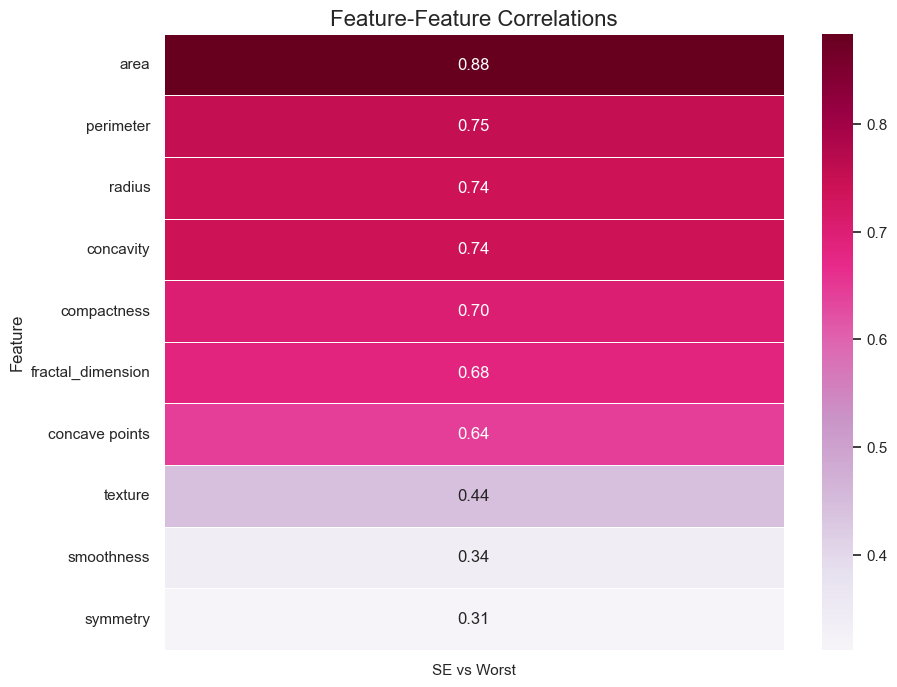

In [44]:
# Extract the base feature names (before "_mean")
base_features = [col.replace('_se', '') for col in df.columns if '_se' in col]

# Ensure all three forms exist
valid_groups = [
    (f"{base}_se", f"{base}_worst")
    for base in base_features
    if  f"{base}_se" in df.columns and f"{base}_worst" in df.columns
]

# Compute pairwise correlations
correlations = []
for se, worst in valid_groups:
    correlations.append({
        'Feature': se.replace('_se', ''),
        'SE vs Worst': df[se].corr(df[worst])
    })

# Create DataFrame
corr_df = pd.DataFrame(correlations).set_index('Feature').sort_values(by='SE vs Worst', ascending=False)

# Visualize as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='PuRd', fmt=".2f", linewidths=.5)
plt.title('Feature-Feature Correlations', fontsize=16)

**Decision:**

Drop se features for highly correlated measures (r ≥ 0.6) and test keeping only texture_se, smoothness_se, and symmetry_se. If their AUC impact is negligible, They better be dropped too

In [46]:
# AUC worst only VS worst and se
#-----------------------------------------
y = df['diagnosis']
se_features = [col for col in df.columns if '_se' in col]
worst_features = [col for col in df.columns if '_worst' in col]

# Case 1: Only worst features
X_worst = df[worst_features]
score_worst = cross_val_score(RandomForestClassifier(), X_worst, y, cv=5, scoring='roc_auc').mean()

# Case 2: Mean + worst features
X_both = df[worst_features + se_features]
score_both = cross_val_score(RandomForestClassifier(), X_both, y, cv=5, scoring='roc_auc').mean()

print(f"AUC (worst only): {score_worst:.3f}, AUC (se + worst): {score_both:.3f}")

AUC (worst only): 0.988, AUC (se + worst): 0.991


In [47]:
# AUC worst only VS worst and selected se
#-------------------------------------------------
# Drop redundant 'se' features (high correlation with 'worst')
high_corr_pairs = ['area', 'perimeter', 'radius', 'concavity', 'compactness', 'fractal_dimension', 'concave points']
se_to_drop = [f"{feat}_se" for feat in high_corr_pairs]
df_filtered = df.drop(columns=[col for col in se_to_drop])

# Keep 'se' for low-correlation features
se_to_test = ['texture_se', 'smoothness_se', 'symmetry_se']

# Validate AUC impact
X_worst_only = df[[col for col in df.columns if '_worst' in col]]
X_hybrid = pd.concat([X_worst_only, df[se_to_test]], axis=1)

auc_worst = cross_val_score(RandomForestClassifier(), X_worst_only, y, cv=5, scoring='roc_auc').mean()
auc_hybrid = cross_val_score(RandomForestClassifier(), X_hybrid, y, cv=5, scoring='roc_auc').mean()

print(f"AUC (worst only): {auc_worst:.3f}, AUC (worst + selected 'se'): {auc_hybrid:.3f}")

AUC (worst only): 0.988, AUC (worst + selected 'se'): 0.989


Again, since `score_both` & `score_worse` don't differ significantly (e.g., +0.03 AUC), then se features don't add much value (even the selected ones) so they better be dropped to avoid Multicollinearity.

In [49]:
# Drop se features for good
df = df.drop(columns=[col for col in df.columns if '_se' in col])

In [50]:
df

,diagnosis,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,25.3800,17.330,184.600,2019.00,0.162200,0.65874,0.711900,0.254280,0.45672,0.11890
1,1,24.9900,23.410,158.800,1956.00,0.123800,0.18660,0.241600,0.186000,0.27500,0.08902
2,1,23.5700,25.530,152.500,1709.00,0.144400,0.42450,0.450400,0.243000,0.36130,0.08758
3,1,14.9100,26.500,98.870,567.70,0.180280,0.65874,0.686900,0.254280,0.45672,0.12822
4,1,22.5400,16.670,152.200,1575.00,0.137400,0.20500,0.400000,0.162500,0.23640,0.07678
...,...,...,...,...,...,...,...,...,...,...,...
564,1,25.4500,26.400,166.100,2027.00,0.141000,0.21130,0.410700,0.221600,0.20600,0.07115
565,1,23.6900,38.250,155.000,1731.00,0.116600,0.19220,0.321500,0.162800,0.25720,0.06637
566,1,18.9800,34.120,126.700,1124.00,0.113900,0.30940,0.340300,0.141800,0.22180,0.07820
567,1,25.7400,38.492,184.600,1821.00,0.165000,0.65874,0.742000,0.254280,0.40870,0.12400


---

#### **Second) Check Feature-Target Correlation**

**Goal:** Filter out features with no predictive power.

**Why?**

Now that only non-redundant features were evaluated, so weak correlations are truly uninformative.


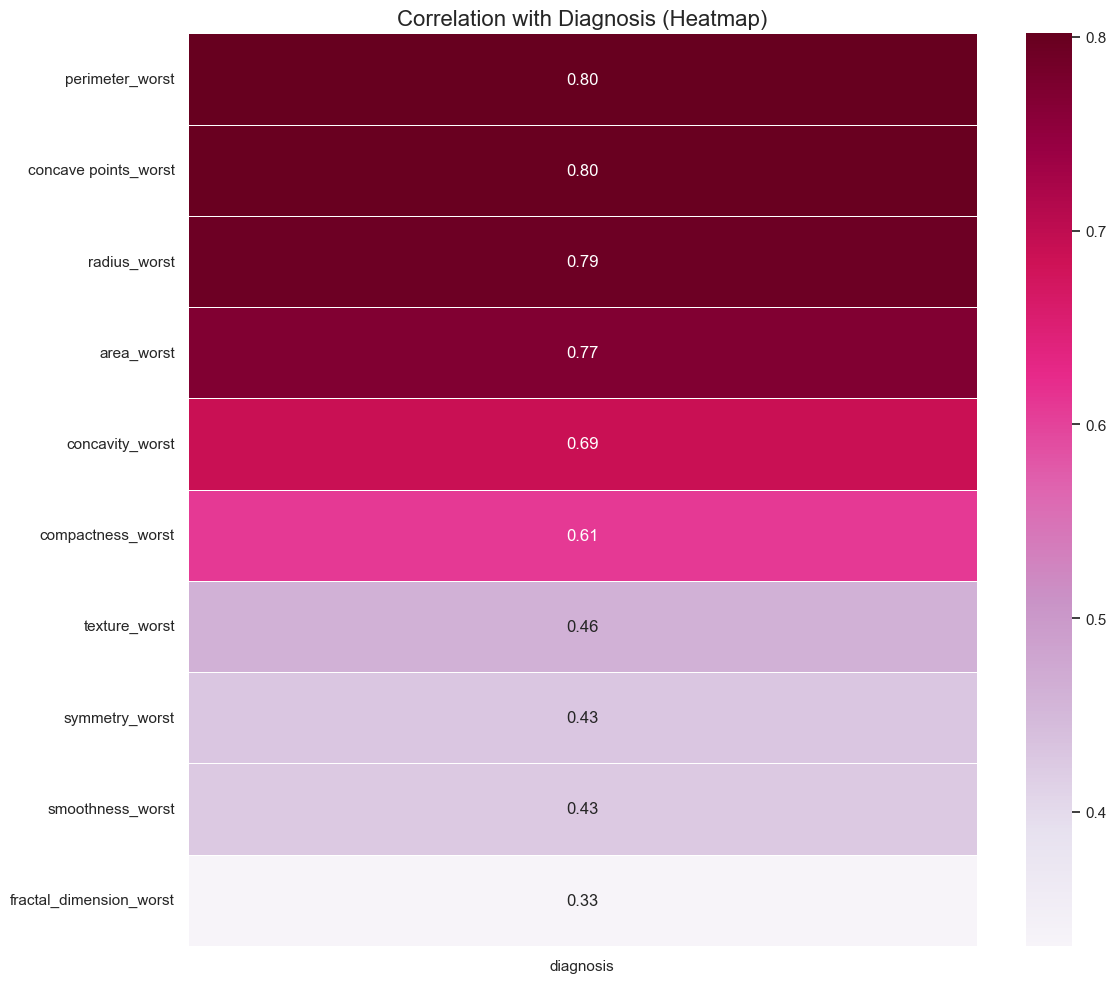

In [53]:
corr_matrix = df.corr()

# Select correlations with the target variable ('diagnosis')
target_corr = corr_matrix['diagnosis'].drop('diagnosis').abs().sort_values(ascending=False)

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='PuRd', fmt=".2f", linewidths=.5)
plt.title('Correlation with Diagnosis (Heatmap)', fontsize=16)
plt.tight_layout()
plt.show()

Selecting only features with (corr > 50%) with target to keep in dataframe

In [55]:
# Calculate correlations with target and filter
corr_with_target = df.corr()['diagnosis'].drop('diagnosis').abs()
features_to_keep = corr_with_target[corr_with_target > 0.5].index.tolist()

# Add the target variable back to the list of features to keep
features_to_keep.append('diagnosis')

# Create a new DataFrame with selected features
df = df[features_to_keep]

In [56]:
df

,radius_worst,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst,diagnosis
0,25.3800,184.600,2019.00,0.65874,0.711900,0.254280,1
1,24.9900,158.800,1956.00,0.18660,0.241600,0.186000,1
2,23.5700,152.500,1709.00,0.42450,0.450400,0.243000,1
3,14.9100,98.870,567.70,0.65874,0.686900,0.254280,1
4,22.5400,152.200,1575.00,0.20500,0.400000,0.162500,1
...,...,...,...,...,...,...,...
564,25.4500,166.100,2027.00,0.21130,0.410700,0.221600,1
565,23.6900,155.000,1731.00,0.19220,0.321500,0.162800,1
566,18.9800,126.700,1124.00,0.30940,0.340300,0.141800,1
567,25.7400,184.600,1821.00,0.65874,0.742000,0.254280,1


---

#### **Finally) Validating with VIF/Modeling & Feature Importance Analysis**

**Goal:** Confirm no lingering multicollinearity.

Compare model performance (e.g., AUC) with/without borderline features.

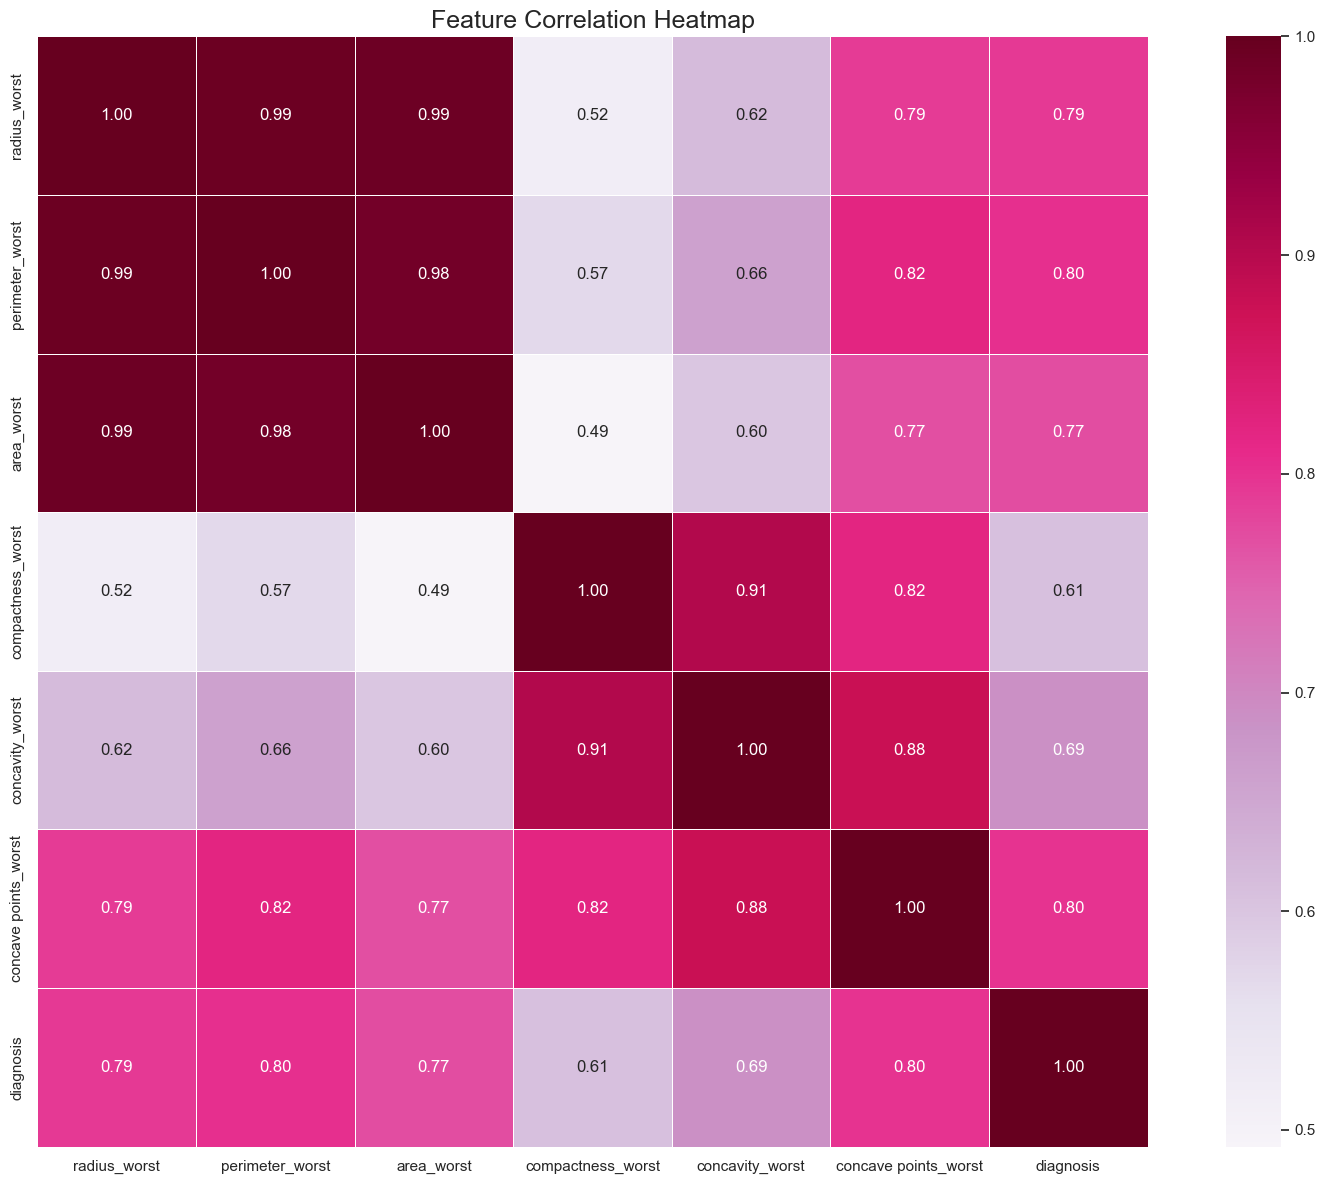

In [59]:
# Compute correlation matrix (numeric columns only)
corr_matrix = df.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Draw the heatmap
sns.heatmap(corr_matrix, cmap='PuRd', annot=True, fmt='.2f', square=True, linewidths=0.5)

plt.title('Feature Correlation Heatmap', fontsize=18)
plt.tight_layout()
plt.show()

Key Takeaway: the dataset has structural redundancies and high Multicolinearity, especially for main features:
- `radius`
- `perimeter`
- `area`

Methods: **VIF** combined with **Feature Importance** Analysis.



---

**Variance Inflation Factor (VIF)** to detect and resolve multicollinearity (highly correlated features)

---

**What is VIF?**
- **VIF measures how much a feature's variance is inflated due to correlation with other features.**  
- **Interpretation:**  
  - `VIF = 1`: No correlation with other features.  
  - `1 < VIF < 5`: Moderate correlation (usually acceptable).  
  - `VIF ≥ 5-10`: High multicollinearity (consider dropping the feature).  

---

**How VIF is Calculated for Each Feature:**
1. **Regress the `i-th` feature** against all other features.  
2. **Compute the R²** (coefficient of determination) from this regression.  
3. **VIF = 1 / (1 - R²)**.  



In [63]:
# Calculating VIF for each feature (Converting df to NumPy array)
vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1]) if i != df.columns.get_loc('diagnosis')]

In [64]:
# Create a DataFrame to display VIF scores
vif_results = pd.DataFrame({
    "Feature": [col for col in df.columns if col != 'diagnosis'],
    "VIF": vif
})
vif_results.sort_values("VIF", ascending=False)

,Feature,VIF
1,perimeter_worst,1523.141220
0,radius_worst,1313.170776
5,concave points_worst,36.825225
2,area_worst,29.228756
3,compactness_worst,26.802820
4,concavity_worst,23.598339


To Analyse and Visualize the Feature Importance according to target, the most straight-forward way is to use a ML classifier model that actually computes it (e.g. **RandomForest**, Logistic Regression, etc)

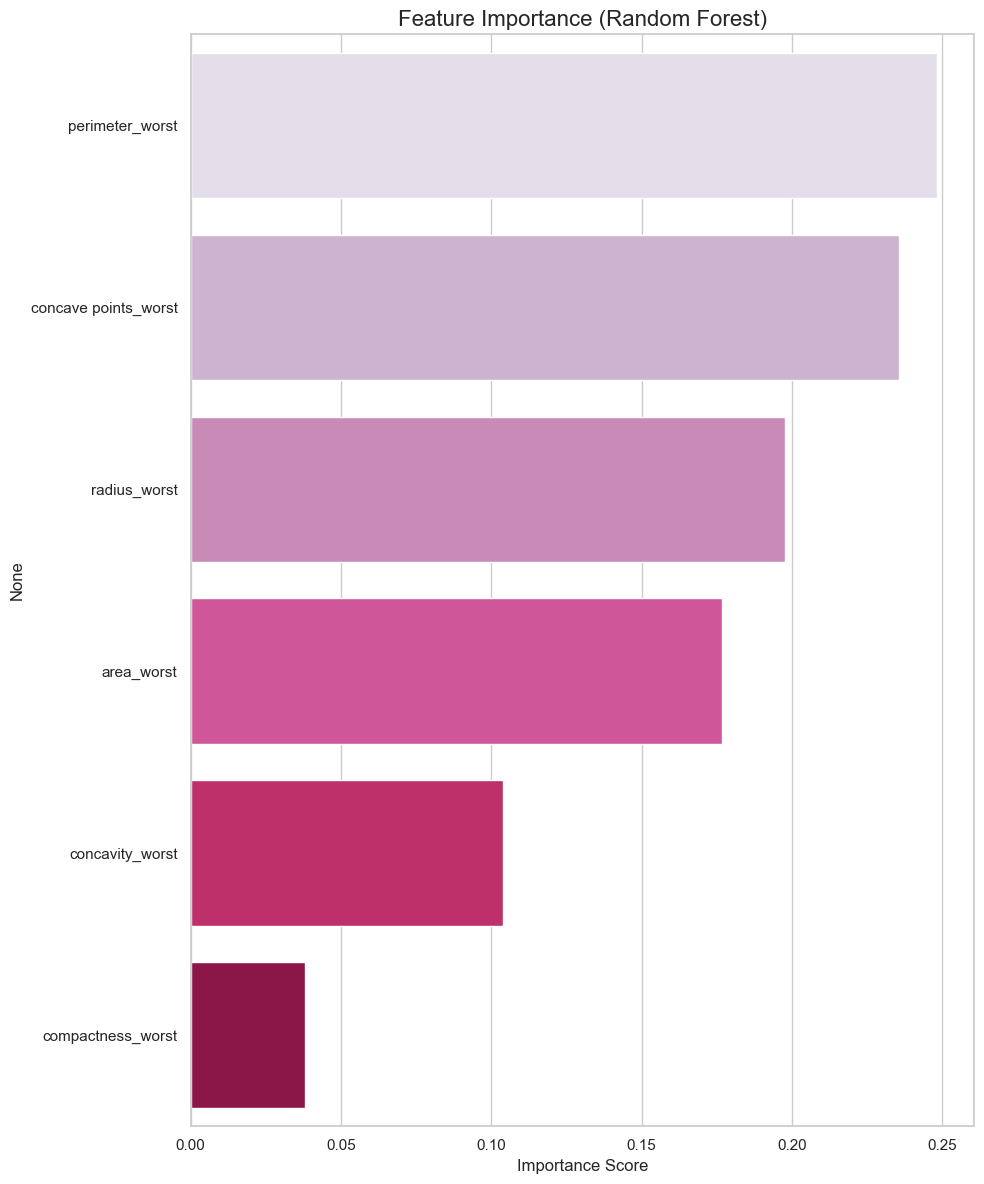

In [66]:
# Prepare features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Train a Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(x=importances.values, y=importances.index, hue= importances.index, palette='PuRd', legend=False)
plt.title("Feature Importance (Random Forest)", fontsize=16)
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [67]:
df_filtered = df.drop(columns=[
    "perimeter_worst",
    "area_worst",            # Keep perimeter_worst
    "compactness_worst",      # Keep concavity_worst
    "concave points_worst", # Keep concavity_wors
])

In [68]:
vif = [variance_inflation_factor(df_filtered.values, i) for i in range(df_filtered.shape[1]) if df_filtered.columns[i] != 'diagnosis']
pd.DataFrame({"Feature": [col for col in df_filtered.columns if col != 'diagnosis'], "VIF": vif}).sort_values("VIF", ascending=False)

,Feature,VIF
1,concavity_worst,5.603437
0,radius_worst,4.450238


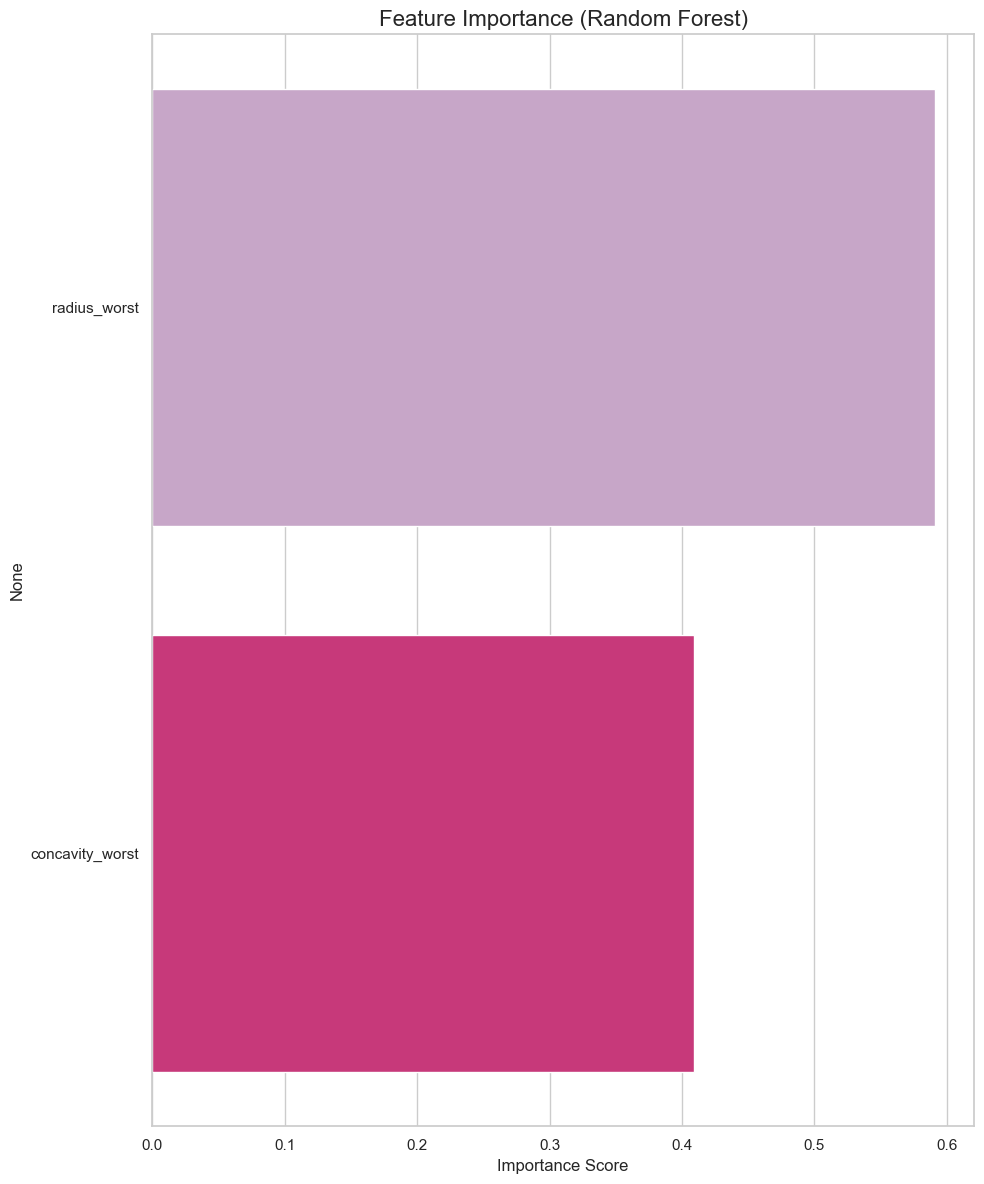

In [69]:
# Prepare features and target
X = df_filtered.drop('diagnosis', axis=1)
y = df_filtered['diagnosis']

# Train a Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(x=importances.values, y=importances.index, hue= importances.index, palette='PuRd', legend=False)
plt.title("Feature Importance (Random Forest)", fontsize=16)
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [70]:
# AUC X  VS Filtered X
#-----------------------------------------
y = df['diagnosis']
features = [col for col in df.columns if col != 'diagnosis']
filtered_features = [col for col in df_filtered.columns if col != 'diagnosis']

# Case 1:  features
X= df[features]
score_features = cross_val_score(RandomForestClassifier(), X, y, cv=5, scoring='roc_auc').mean()

# Case 2: filtered features
X_filtered = df[filtered_features]
score_filtered = cross_val_score(RandomForestClassifier(), X_filtered, y, cv=5, scoring='roc_auc').mean()

print(f"AUC (X): {score_features:.3f}, AUC (Filtered X): {score_filtered:.3f}")

AUC (X): 0.982, AUC (Filtered X): 0.978


Since the AUC Score between X and filtered X is not differeing much, Our filtereation process is mostly valid.

In [72]:
df = df_filtered
df

,radius_worst,concavity_worst,diagnosis
0,25.3800,0.711900,1
1,24.9900,0.241600,1
2,23.5700,0.450400,1
3,14.9100,0.686900,1
4,22.5400,0.400000,1
...,...,...,...
564,25.4500,0.410700,1
565,23.6900,0.321500,1
566,18.9800,0.340300,1
567,25.7400,0.742000,1


---

### **3- Feature Engineering & Transformation**

#### **First) Checking Skewness**

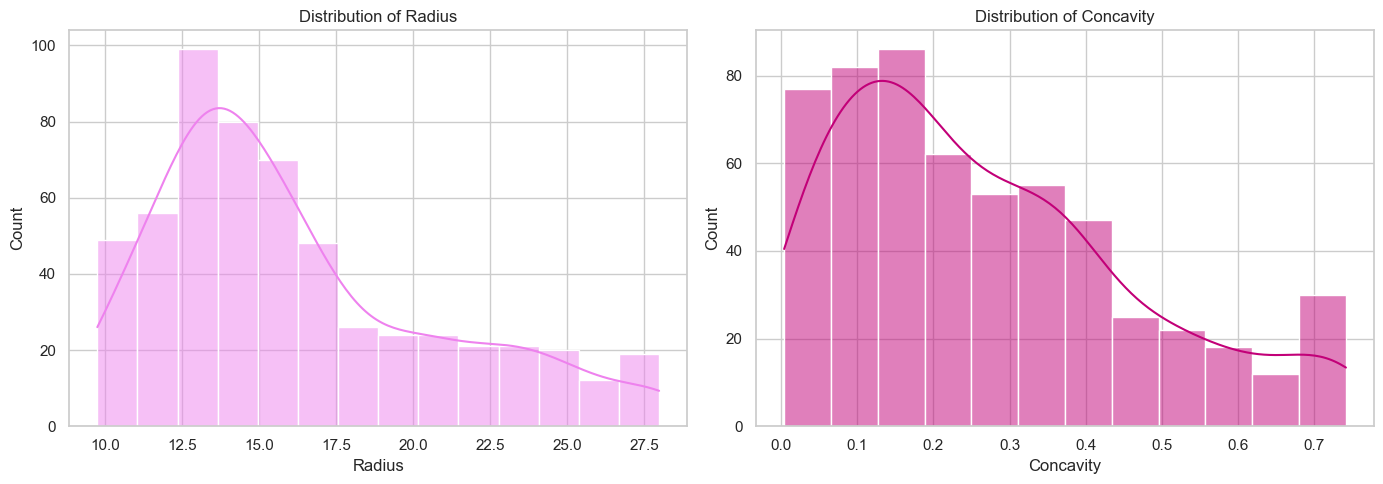

In [76]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First feature
sns.histplot(df['radius_worst'], kde=True, ax=axes[0], color='#EE82EE')
axes[0].set_title(f'Distribution of Radius')
axes[0].set_xlabel('Radius')

# Second feature
sns.histplot(df['concavity_worst'], kde=True, ax=axes[1], color='#C20078')
axes[1].set_title(f'Distribution of Concavity')
axes[1].set_xlabel('Concavity')

# Adjust spacing
plt.tight_layout()
plt.show()

Since Data is Right Skewed, It's better to transform it using Log Transformation.

**What is Log transformation ?**

a mathematical technique used to reduce skewness, compress large values, and stabilize variance in numeric data. It’s especially data has a right-skewed (long tail to the right) distribution.

In [79]:
# Apply log transformation
df['log_radius'] = np.log(df['radius_worst'])  # radius has no zeroes
df['log_concavity'] = np.log1p(df['concavity_worst'])  # safe for 0 values

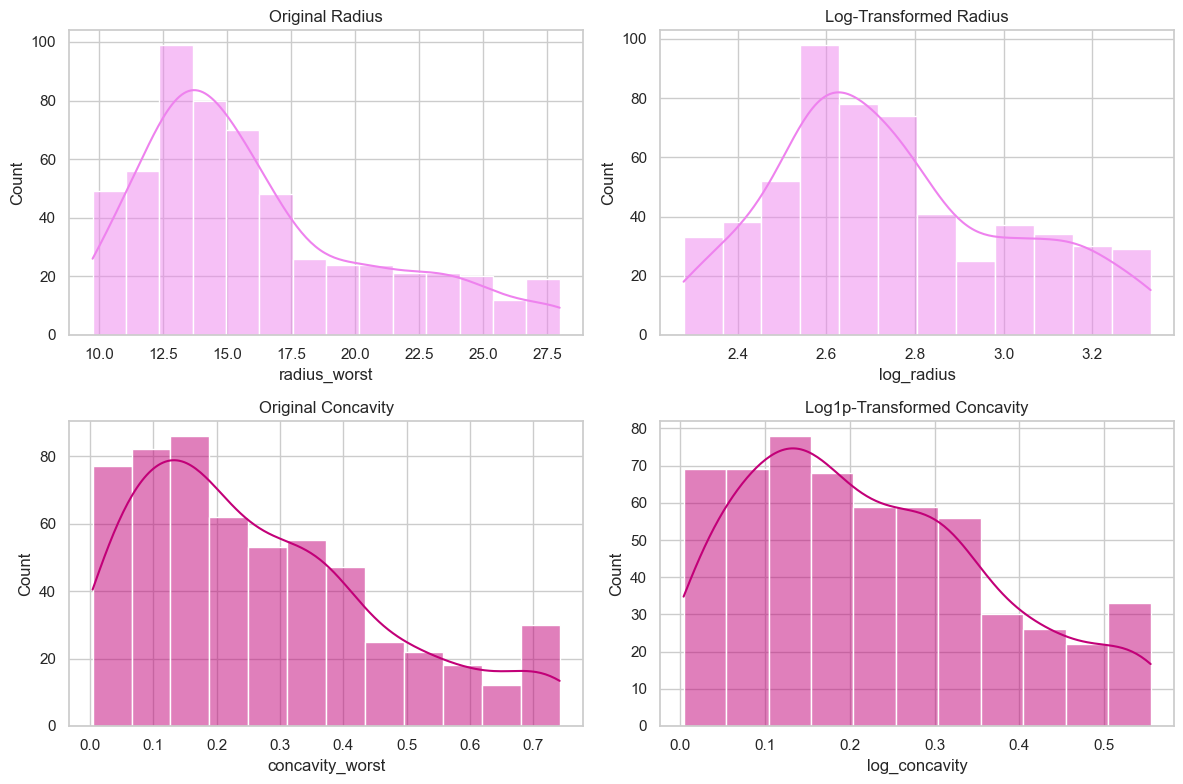

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['radius_worst'], kde=True, ax=axes[0, 0], color= '#EE82EE')
axes[0, 0].set_title("Original Radius")
sns.histplot(df['log_radius'], kde=True, ax=axes[0, 1], color= '#EE82EE')
axes[0, 1].set_title("Log-Transformed Radius")

sns.histplot(df['concavity_worst'], kde=True, ax=axes[1, 0], color= '#C20078')
axes[1, 0].set_title("Original Concavity")
sns.histplot(df['log_concavity'], kde=True, ax=axes[1, 1], color= '#C20078')
axes[1, 1].set_title("Log1p-Transformed Concavity")

plt.tight_layout()
plt.show()

In [81]:
# Compare Skewness Numerically
print('Radius:')
print("Skewness before log:", df['radius_worst'].skew())
print("Skewness after log:", df['log_radius'].skew())
print('-----------------------------------------------------------')
print('Concavity:')
print("Skewness before log:", df['concavity_worst'].skew())
print("Skewness after log:", df['log_concavity'].skew())

Radius:
Skewness before log: 0.9038586381760184
Skewness after log: 0.43306816766464734
-----------------------------------------------------------
Concavity:
Skewness before log: 0.7585786475443118
Skewness after log: 0.5016237471730887


In [82]:
df.drop(columns=['radius_worst', 'concavity_worst'], inplace=True)

---

#### **Second) Standardizing/Nomalizing data**

In [85]:
# Standardize all features
scaler = StandardScaler()

# Select the features to scale (excluding 'diagnosis')
features_to_scale = [col for col in df.columns if col != 'diagnosis']

# 3. Fit the scaler to the selected features
scaler.fit(df[features_to_scale])

# 4. Transform the selected features and update the DataFrame
df[features_to_scale] = scaler.transform(df[features_to_scale])

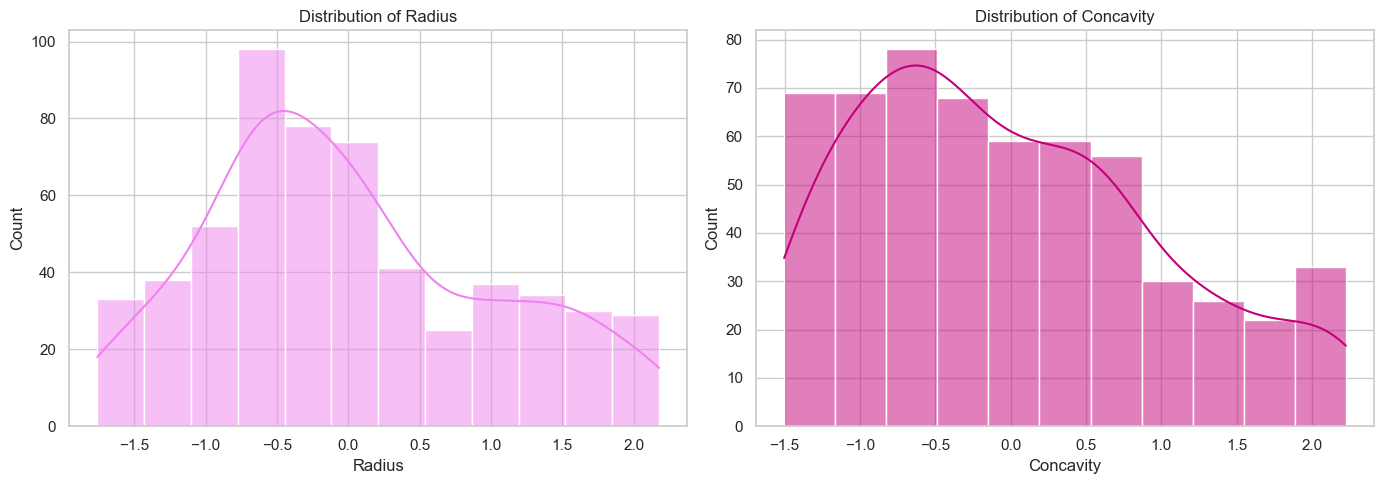

In [86]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First feature
sns.histplot(df['log_radius'], kde=True, ax=axes[0], color= '#EE82EE')
axes[0].set_title(f'Distribution of Radius')
axes[0].set_xlabel('Radius')

# Second feature
sns.histplot(df['log_concavity'], kde=True, ax=axes[1], color= '#C20078')
axes[1].set_title(f'Distribution of Concavity')
axes[1].set_xlabel('Concavity')

# Adjust spacing
plt.tight_layout()
plt.show()

In [87]:
# Rename Features
df.rename(columns={'log_radius': 'radius', 'log_concavity': 'concavity'}, inplace=True)
df.head()

,diagnosis,radius,concavity
0,1,1.812550,2.106038
1,1,1.754702,-0.065638
2,1,1.536170,0.985293
3,1,-0.174490,2.006573
4,1,1.369254,0.746173


---

#### **Finally) Checking the need for adding polynomial features**

**A. Partial dependence plots (PDP)**

plots that show dependence between target and input features of interest, while marginalizing over the values of all other input features.

PDPs are essential to visualize the relationship between a specific feature and the model’s predictions while holding all other features constant.

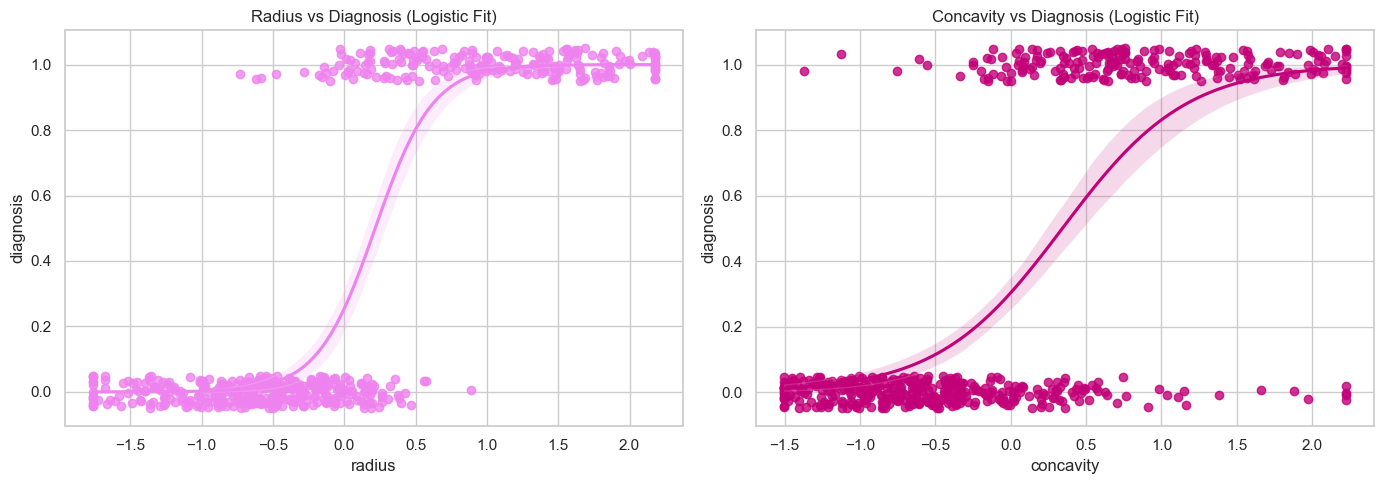

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.regplot(x='radius', y='diagnosis', data=df, logistic=True, y_jitter=0.05, ax=axes[0], color= '#EE82EE')
axes[0].set_title("Radius vs Diagnosis (Logistic Fit)")

sns.regplot(x='concavity', y='diagnosis', data=df, logistic=True, y_jitter=0.05, ax=axes[1], color= '#C20078')
axes[1].set_title("Concavity vs Diagnosis (Logistic Fit)")

plt.tight_layout()
plt.show()

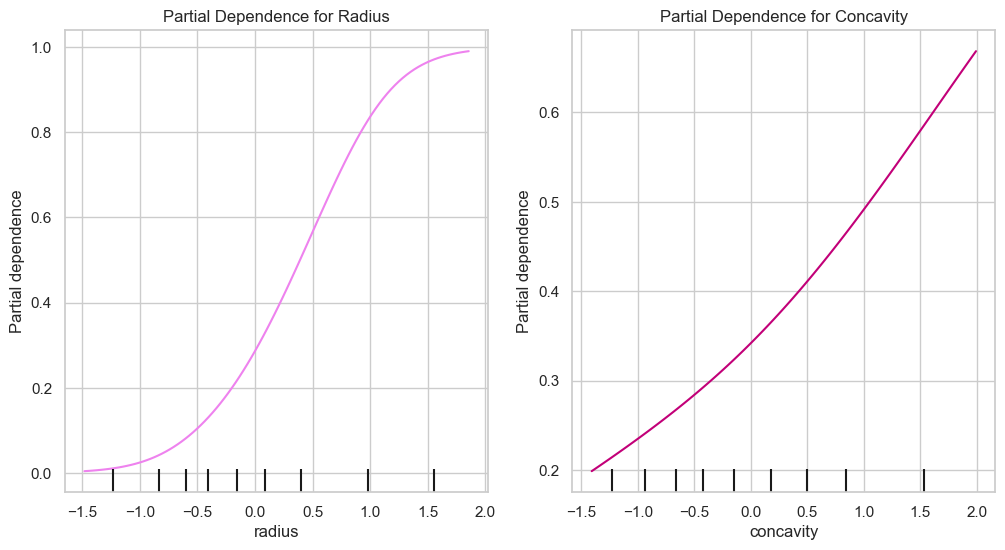

In [92]:
model = LogisticRegression().fit(df[['radius', 'concavity']], df['diagnosis'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Partial dependence for 'radius' (on the first subplot)
PartialDependenceDisplay.from_estimator(
    model, df[['radius', 'concavity']], ['radius'], ax=ax1, line_kw={'color': '#EE82EE'}
)
ax1.set_title("Partial Dependence for Radius")

# Partial dependence for 'concavity' (on the second subplot)
PartialDependenceDisplay.from_estimator(
    model, df[['radius', 'concavity']], ['concavity'], ax=ax2 , line_kw={'color': '#C20078'}
)
ax2.set_title("Partial Dependence for Concavity")

plt.show()

Since the **PDP curve** does not deviate significantly from linear, polynomial terms are not that needed.

However the PDP curve looks a bit lineared, since PDP Averages Over Other Features_
PDP shows the marginal effect of concavity while averaging out all other features (radius). this averaging can "flatten" nonlinearities. and it indicates thet other features (radius) interact strongly with concavity.

**B. Check for Feature Interactions:**

Plot concavity vs diagnosis stratified by another feature (radius):

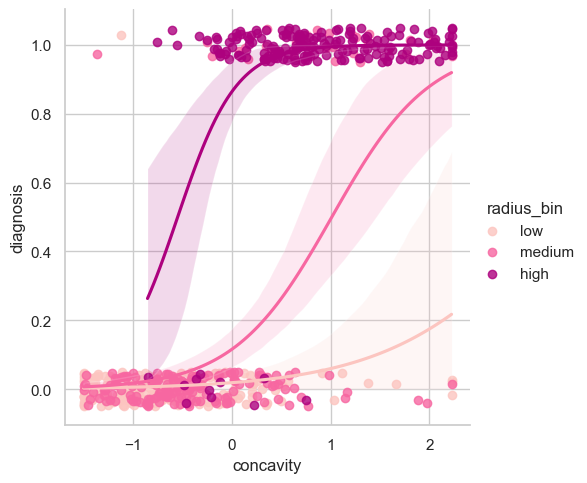

In [95]:
# Bin 'radius' into tertiles to stratify
df['radius_bin'] = pd.qcut(df['radius'], q=3, labels=["low", "medium", "high"])

# Plot interaction
sns.lmplot(
    data=df,
    x='concavity',
    y='diagnosis',
    hue='radius_bin',
    logistic=True,
    y_jitter=0.05,
    palette='RdPu'
)

Lines are not crossed and their slopes don't differ much, that's often a sign of no need to add an interaction term.

**C. Validate with Model Performance**

Compare AUC/F1 with and without interaction terms

In [98]:
# Add an interaction term
df['concavity_x_radius'] = df['concavity'] * df['radius']

# Without interaction
X_basic = df[['concavity', 'radius']]
auc_basic = cross_val_score(LogisticRegression(), X_basic, y, cv=5, scoring='roc_auc').mean()

# With interaction
X_interaction = df[['concavity', 'radius', 'concavity_x_radius']]
auc_interaction = cross_val_score(LogisticRegression(), X_interaction, y, cv=5, scoring='roc_auc').mean()

print(f"AUC (Basic): {auc_basic:.3f}, AUC (Interaction): {auc_interaction:.3f}")

AUC (Basic): 0.986, AUC (Interaction): 0.985


As Validated by the comparison between AUC Scores, feature interaction are just an Option here!

**D. Validate with correlation**

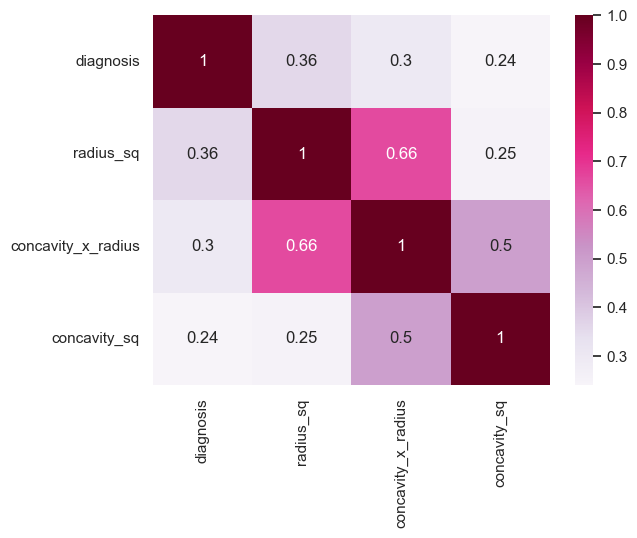

In [101]:
# Generate polynomial features
df['radius_sq'] = df['radius'] ** 2
df['concavity_sq'] = df['concavity'] ** 2

# Calculate correlation matrix
corr_matrix = df[['diagnosis', 'radius_sq', 'concavity_x_radius','concavity_sq']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='PuRd')
plt.show()

since polynomial features do not correlate more strongly with diagnosis than the originals, they 're mostly not that useful.

In [103]:
# Keep Only the Original Features
df.drop(columns=['radius_sq', 'concavity_x_radius','radius_bin','concavity_sq'], inplace=True)

---

## **3. Preparing Data for Classification**

### **1- Check for class imbalanc**e

In [107]:
df['diagnosis'].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

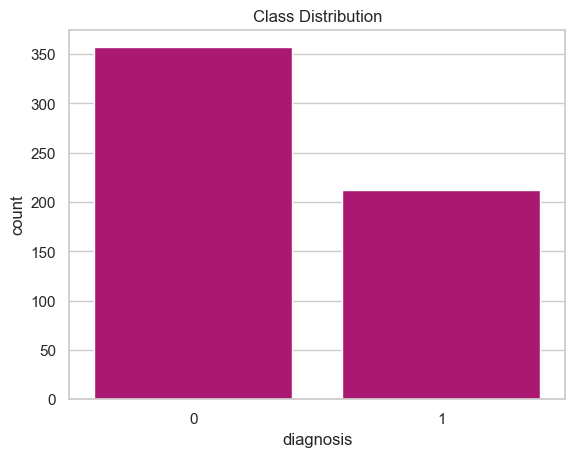

In [108]:
# bar plot
sns.countplot(x='diagnosis', data=df , color='#C20078')
plt.title('Class Distribution')
plt.show()

Visualize Data to check for Class ovelapps, In order to determine balancing approach:

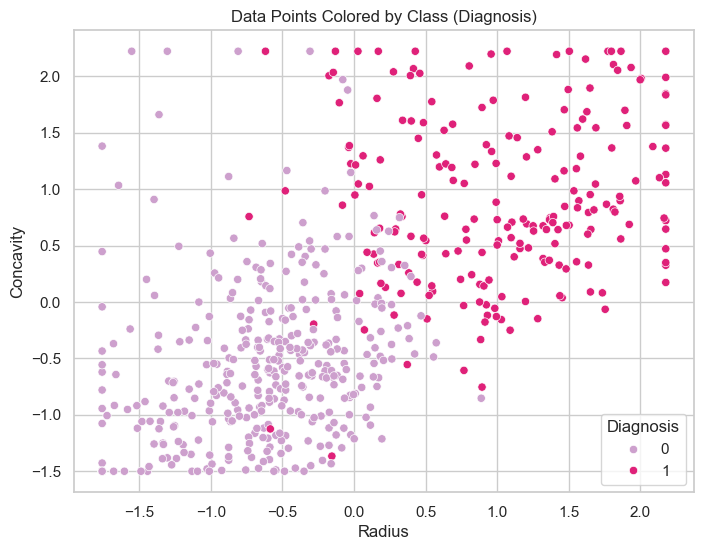

In [110]:
# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='radius', y='concavity', hue='diagnosis', palette='PuRd')
plt.title("Data Points Colored by Class (Diagnosis)")
plt.xlabel("Radius")
plt.ylabel("Concavity")
plt.legend(title='Diagnosis')
plt.show()

Since Data is well distributed with not so many Overlapps, It's safe to use SMOTE.

#### **SMOTE (Synthetic Minority Over-sampling Technique)**
a method used to balance imbalanced datasets by generating synthetic examples for the minority class, rather than duplicating existing ones (avoiding potential overfitting).

**How SMOTE Works (Step-by-Step):**
1. Find k Nearest Neighbors:

For each instance
𝑥 in the minority class, find its
𝑘 nearest neighbors (typically
𝑘
=
5) in feature space.

2. Choose Neighbors Randomly:

Randomly select one (or more) of the
𝑘 neighbors.

3. Generate Synthetic Point:

Create a synthetic point by interpolating between the original point and the selected neighbor:

4. Repeat until the desired balance is reached.

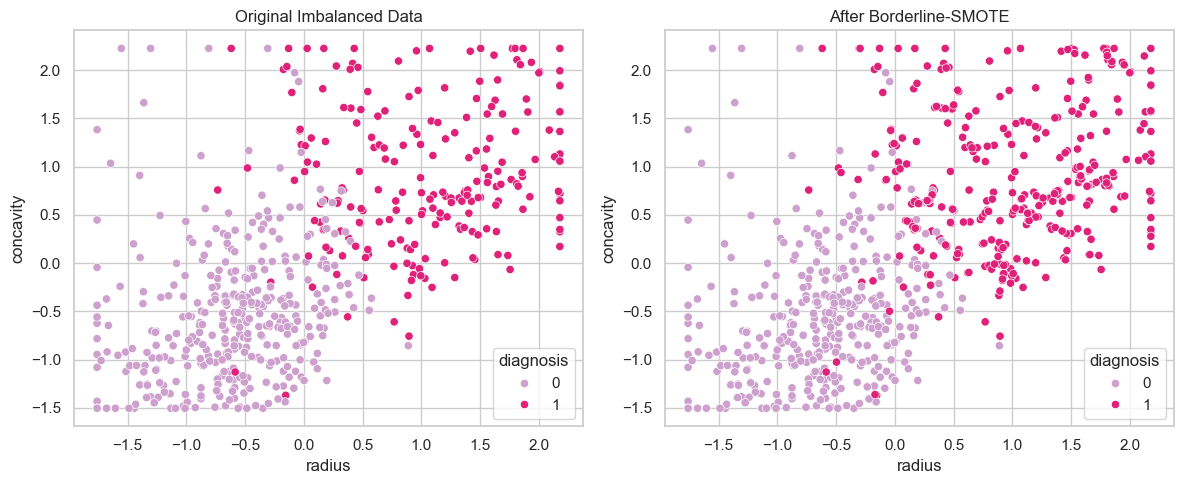

In [113]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Create a new DataFrame with resampled data
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['diagnosis'] = y_res  # Add the resampled target

# Visualize original vs. resampled
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original data
sns.scatterplot(data=df, x=df.columns[1], y=df.columns[2], hue='diagnosis', ax=axes[0], palette='PuRd')
axes[0].set_title('Original Imbalanced Data')

# Resampled data
sns.scatterplot(data=df_resampled, x=df_resampled.columns[0], y=df_resampled.columns[1], hue='diagnosis', ax=axes[1], palette='PuRd')
axes[1].set_title('After Borderline-SMOTE')

plt.tight_layout()
plt.show()

In [114]:
# Check Re-sampling
df_resampled['diagnosis'].value_counts()

diagnosis
1    357
0    357
Name: count, dtype: int64

#### **Validate with AUC score:**

In [116]:
# AUC X  VS Balanced X
#-----------------------------------------
y = df['diagnosis']
features = [col for col in df.columns if col != 'diagnosis']
balanced_features = [col for col in df_resampled.columns if col != 'diagnosis']

# Case 1: features
X= df[features]
score_features= cross_val_score(RandomForestClassifier(), X, y, cv=5, scoring='roc_auc').mean()

# Case 2: balanced features
X_balanced = df[balanced_features]
score_balanced = cross_val_score(RandomForestClassifier(), X_balanced, y, cv=5, scoring='roc_auc').mean()

print(f"AUC (X): {score_features:.3f}, AUC (Balanced X): {score_balanced:.3f}")

AUC (X): 0.977, AUC (Balanced X): 0.981


In [117]:
# Apply re-sampling to original data
df = df_resampled

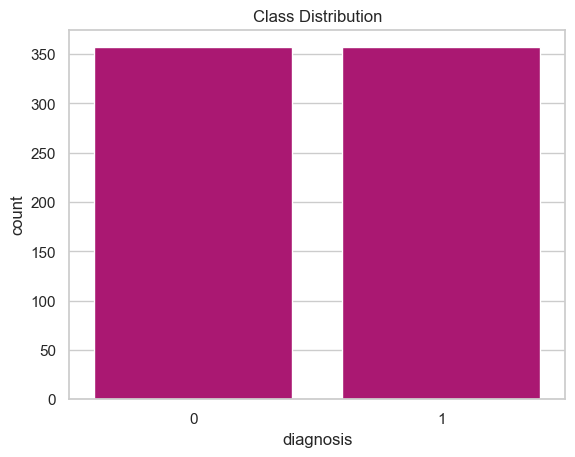

In [118]:
# Bar Plot
sns.countplot(x='diagnosis', data=df, color='#C20078')
plt.title('Class Distribution')
plt.show()

In [119]:
df.shape

(714, 3)

In [120]:
df.sample(10)

,radius,concavity,diagnosis
80,-0.655091,-0.435518,0
489,0.766252,-0.032502,1
131,0.781800,0.644479,1
93,-0.127188,-0.654126,0
264,1.206667,0.692354,1
449,1.856446,0.936169,1
423,-0.117306,0.579949,0
180,2.177939,1.364178,1
663,1.039056,0.044609,1
681,1.225983,0.595602,1


---

### **2- Train/Test Splitting**

#### **Cross Validation to Find Optimal Train/Test Split**

In [124]:
# Tested train sizes (50%, 60%, 70%, 80%)
train_sizes = [0.5, 0.6, 0.7, 0.8]

In [125]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

model = LogisticRegression(max_iter=1000, class_weight='balanced')
results = {}

for train_size in train_sizes:
    # Configure CV to mimic train-test split (10 iterations per ratio)
    cv = ShuffleSplit(n_splits=10, train_size=train_size, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    results[f"Train={int(train_size*100)}%"] = {
        "Mean AUC": np.mean(scores),
        "Std AUC": np.std(scores)
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

           Mean AUC   Std AUC
Train=50%  0.983569  0.002233
Train=60%  0.983549  0.003177
Train=70%  0.983942  0.005177
Train=80%  0.983850  0.005917


**Optimal Choice:**
- Train = 70%
 - Highest Mean AUC

 - Acceptable Std AUC (variance)

It gives the best trade-off between performance and stability.

In [127]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

---
---

### Support Vector Machine (SVM) Implementation

In [ ]:
# Define multiple SVM models with different kernels
# Kernel functions determine how the input data is transformed.
# - 'rbf' (Radial Basis Function): Good for non-linear problems (default kernel).
# - 'linear': Best when the data is linearly separable.
# - 'poly': Captures more complex, polynomial decision boundaries.
# --------------------------
svm_models = {
    "SVC (RBF kernel)": SVC(kernel='rbf', random_state=42),
    "Linear SVM": SVC(kernel='linear', random_state=42),
    "Polynomial SVM": SVC(kernel='poly', degree=3, random_state=42)
}

# --------------------------
# random_state=42:
# Ensures that the train-test split (or anything randomized) is reproducible.
# Choosing 42 is a common convention in machine learning 
# (popularized by scikit-learn tutorials and as a reference to “The Hitchhiker's Guide to the Galaxy”).
# --------------------------


In [131]:
# Print a title for the SVM evaluation section
print("\nSVM Models:\n")

# --------------------------
# Loop through each defined SVM model
# Fit the model to the training data
# Predict the labels on the test data
# Evaluate the predictions using multiple metrics
# --------------------------
for name, model in svm_models.items():
    # Train the model using the scaled training data
    model.fit(X_train, y_train)

    # Make predictions on the scaled test data
    y_pred = model.predict(X_test)

    # --------------------------
    # accuracy_score: Proportion of correct predictions
    # classification_report: Gives precision, recall, f1-score, and support
    # - precision: True positives / (true positives + false positives)
    # - recall: True positives / (true positives + false negatives)
    # - f1-score: Harmonic mean of precision and recall
    # - support: Number of actual instances per class
    # --------------------------
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Print the classification report for both classes (0 = Benign, 1 = Malignant)
    print(classification_report(y_test, y_pred, target_names=['Benign (0)', 'Malignant (1)']))



SVM Models:

SVC (RBF kernel) Accuracy: 0.9721
               precision    recall  f1-score   support

   Benign (0)       0.96      0.98      0.97       108
Malignant (1)       0.98      0.96      0.97       107

     accuracy                           0.97       215
    macro avg       0.97      0.97      0.97       215
 weighted avg       0.97      0.97      0.97       215

Linear SVM Accuracy: 0.9628
               precision    recall  f1-score   support

   Benign (0)       0.96      0.96      0.96       108
Malignant (1)       0.96      0.96      0.96       107

     accuracy                           0.96       215
    macro avg       0.96      0.96      0.96       215
 weighted avg       0.96      0.96      0.96       215

Polynomial SVM Accuracy: 0.8837
               precision    recall  f1-score   support

   Benign (0)       0.81      1.00      0.90       108
Malignant (1)       1.00      0.77      0.87       107

     accuracy                           0.88       215
    

📊 Performance Metrics Summary

| Kernel         | Accuracy | Precision (avg) | Recall (avg) | F1-Score (avg) |
| -------------- | -------- | --------------- | ------------ | -------------- |
| **RBF**        | 0.9721   | 0.97            | 0.97         | 0.97           |
| **Linear**     | 0.9628   | 0.96            | 0.96         | 0.96           |
| **Polynomial** | 0.8837   | 0.91            | 0.88         | 0.88           |


✅ Best Performing Model: SVC with RBF Kernel
Detailed Classification Report:

Accuracy: 97.21%

                precision    recall  f1-score   support
      Benign       0.96       0.98      0.97       108
      Malignant    0.98       0.96      0.97       107

    Macro avg       0.97       0.97      0.97      215
    Weighted avg    0.97       0.97      0.97      215


## Predict for a new data.

In [135]:
# Reuse your best model from the dictionary
best_model = svm_models["SVC (RBF kernel)"]
# Fit the selected model on the training data
best_model.fit(X_train, y_train)


SVC(random_state=42)

In [136]:
# ✅ New data row for prediction (example values – use actual feature names and order)
new_data = pd.DataFrame({
    'radius' :   [-0.601322],
    'concavity': [1.195777]
})

# Prediction
rbf_pred = best_model.predict(new_data)

#  Output result
print("\nPrediction for new data row:")
print(f"RBF SVM Prediction (0=Benign, 1=Malignant): {rbf_pred[0]}")



Prediction for new data row:
RBF SVM Prediction (0=Benign, 1=Malignant): 0


## GridSearchCV For Best Alpha

In [138]:
# Step 1: Define the parameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],  # Regularization term
    # Optional: add 'max_iter': [200, 300, 500]
}

# Step 2: Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=5, verbose=2, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 3: Get the best parameters
print(f"\nBest Parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Parameters: {'alpha': 0.0001}


## MLP Designs with Various Options

In [140]:
alpha = grid_search.best_params_['alpha']

# Define different model architectures
models = {
    "Simple (10 neurons, Sigmoid)": MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', alpha=alpha, max_iter=500),
    "Deep (64-32-16 neurons, Sigmoid)": MLPClassifier(hidden_layer_sizes=(64, 32, 16), activation='logistic', alpha=alpha, max_iter=500),
    "Simple (10 neurons, ReLU)": MLPClassifier(hidden_layer_sizes=(10,), activation='relu', alpha=alpha, max_iter=500),
    "Deep (64-32-16 neurons, ReLU)": MLPClassifier(hidden_layer_sizes=(64, 32, 16), activation='relu', alpha=alpha, max_iter=500)
}


In [ ]:
results = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Optional: Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores (5-fold): {cv_scores}")
    print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")
    print(".....................................................")



Training model: Simple (10 neurons, Sigmoid)
Accuracy: 0.9721
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       108
           1       0.98      0.96      0.97       107

    accuracy                           0.97       215
   macro avg       0.97      0.97      0.97       215
weighted avg       0.97      0.97      0.97       215

Cross-validation scores (5-fold): [0.94       0.97       0.95       0.89       0.92929293]
Mean cross-validation accuracy: 0.9359
.....................................................

Training model: Deep (64-32-16 neurons, Sigmoid)
Accuracy: 0.9628
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.98      0.94      0.96       107

    accuracy                           0.96       215
   macro avg       0.96      0.96      0.96       215
weighted avg       0.96      0.96      0.

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.ylabel("Accuracy")
plt.title("Model Comparison - MLP Classifiers with Different Configurations")
plt.xticks(rotation=45)
plt.ylim(0.85, 0.97)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


# 🔍 Model Performance Summary

We trained four neural network models with different architectures and activation functions to classify a binary dataset :

### ✅ Models Evaluated
1. **Simple (10 neurons, Sigmoid)**
2. **Deep (64-32-16 neurons, Sigmoid)**
3. **Simple (10 neurons, ReLU)**
4. **Deep (64-32-16 neurons, ReLU)**

---

## 📊 Performance Metrics

| Model                          | Test Accuracy | Mean CV Accuracy | Avg F1-score | Notes                             |
|-------------------------------|---------------|------------------|--------------|-----------------------------------|
| Simple (Sigmoid)              | **0.9721**     | 0.9359           | **0.97**     | Highest test accuracy             |
| Deep (Sigmoid)                | 0.9628         | 0.9379           | 0.96         | Slightly lower performance        |
| Simple (ReLU)                 | 0.9674         | **0.9399**       | **0.97**     | Best cross-validation performance |
| Deep (ReLU)                   | 0.9488         | 0.9258           | 0.95         | Lowest performance overall        |

---

## 🧠 Insights

- **Simple models outperform deep models**: Likely due to the small dataset size—deep models may be overfitting.
- **ReLU generalizes slightly better**: The simple ReLU model had the **highest mean CV accuracy**.
- **Sigmoid shows strong accuracy**: The simple Sigmoid model achieved the **highest test accuracy**.
- **Balanced class performance**: All models had high precision, recall, and f1-scores for both classes (no class imbalance issues).

---

In [ ]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


In [ ]:
print("Hidden layers:", model.hidden_layer_sizes)
print("Number of layers (including input/output):", model.n_layers_)
print("Number of outputs:", model.n_outputs_)
print("Number of features (input):", model.n_features_in_)


# **comparison between SVM and Nueral Network Models**

In [ ]:
# Train MLPClassifier (Neural Network)
mlp_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, activation='relu')
start_time = time.time()
mlp_model.fit(X_train, y_train)
mlp_train_time = time.time() - start_time

# Print MLP details
print("\nMLPClassifier Model Details:")
print("Hidden layers:", mlp_model.hidden_layer_sizes)
print("Number of layers (including input/output):", mlp_model.n_layers_)
print("Number of outputs:", mlp_model.n_outputs_)
print("Number of features (input):", mlp_model.n_features_in_)

# SVM Model (Support Vector Machine)
svm_model = SVC(kernel='rbf')
start_time = time.time()
svm_model.fit(X_train, y_train)
svm_train_time = time.time() - start_time

# Print SVM details
print("\nSVM Model Details:")
print(f"Kernel: {svm_model.kernel}")
print(f"Support vectors count: {len(svm_model.support_)}")

# Predict and evaluate both models
mlp_y_pred = mlp_model.predict(X_test)
svm_y_pred = svm_model.predict(X_test)

print("\nMLPClassifier Accuracy:", accuracy_score(y_test, mlp_y_pred))
print("SVM Accuracy:", accuracy_score(y_test, svm_y_pred))

print("\nMLPClassifier Classification Report:")
print(classification_report(y_test, mlp_y_pred))

print("\nSVM Classification Report:")
print(classification_report(y_test, svm_y_pred))

# Cross-validation scores
mlp_cv_scores = cross_val_score(mlp_model, X_train, y_train, cv=5)
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)

print("\nMLPClassifier Cross-validation Accuracy:", mlp_cv_scores.mean())
print("SVM Cross-validation Accuracy:", svm_cv_scores.mean())

# Print training time for both models
print("\nMLP Training Time:", mlp_train_time)
print("SVM Training Time:", svm_train_time)



### Cross-validation Scores:
- **MLPClassifier Cross-validation Accuracy**: 93.18%
- **SVM Cross-validation Accuracy**: 93.59%

### Training Time:
- **MLP Training Time**: 0.53 seconds
- **SVM Training Time**: 0.02 seconds

## Insights:
- **SVM** provides a slightly higher accuracy (97.21%) compared to **MLPClassifier** (96.74%).
- **Both models** show similar classification reports with high precision, recall, and F1-score, indicating balanced performance.
- **SVM** is much faster to train (0.02 seconds) compared to **MLP** (0.53 seconds), making SVM more efficient for smaller datasets.
- **Cross-validation results** are very close, indicating both models are robust but SVM performs slightly better during cross-validation.

## Conclusion:
- If **training time** and **speed** are important, **SVM** is a better choice due to its much faster training time.
- If **model complexity** and the ability to learn non-linear decision boundaries are critical, **MLPClassifier** may still be a strong option.
